# Sentiment and Emotion Classification Model Training
Using dataset from kaggle consisting of `416,809 observations` of labeled text content from twitter
<br>
Kaggle dataset url: [https://www.kaggle.com/datasets/nelgiriyewithana/emotions](https://www.kaggle.com/datasets/nelgiriyewithana/emotions)

**About the dataset**
<br>
Each entry in this dataset consists of a text segment representing a Twitter message and a corresponding label indicating the predominant emotion conveyed. The emotions are classified into six categories: sadness (0), joy (1), love (2), anger (3), fear (4), and surprise (5). This dataset provides a rich foundation for exploring the nuanced emotional landscape within the realm of social media.

**Dataset features**
* text: twitter text content
* label: emotion classification
  * sadness (0), 
  * joy (1), 
  * love (2), 
  * anger (3), 
  * fear (4), 
  * and surprise (5). 

## Initialization

In [48]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import nltk
import re
import os

from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WordPunctTokenizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2

In [2]:
color_a1 = '#664c85'
color_a2 = '#5b92b6'
color_a3 = '#52d5bd'
color_a4 = '#eeeeee'
palette_a1 = 'mako'
palette_a2 = 'mako_r'

In [3]:
%%capture
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/cabrera/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/cabrera/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/cabrera/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/cabrera/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/cabrera/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/cabrera/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/cabrera/nltk_data...
[nltk_data]   Package averaged_perceptron_ta

Loading the data

In [4]:
df = pd.read_csv('data/dataset.csv', index_col=0)

df.head()

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


Getting the label distribution

In [5]:
df['label'].value_counts().sort_index()

label
0    121187
1    141067
2     34554
3     57317
4     47712
5     14972
Name: count, dtype: int64

Renaming the attribute name from label -> emotion_label

In [6]:
df.rename(columns={
  'label': 'emotion_label'
}, inplace=True)

df.head()

,text,emotion_label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


Adding emotion_label_description attribute

In [7]:
emotion_label_description_map = {
  0: 'sadness',
  1: 'joy',
  2: 'love',
  3: 'anger',
  4: 'fear',
  5: 'surprised',
}

In [8]:
df['emotion_label_description'] = df['emotion_label'].apply(lambda label: emotion_label_description_map.get(label))

df.head()

,text,emotion_label,emotion_label_description
0,i just feel really helpless and heavy hearted,4,fear
1,ive enjoyed being able to slouch about relax a...,0,sadness
2,i gave up my internship with the dmrg and am f...,4,fear
3,i dont know i feel so lost,0,sadness
4,i am a kindergarten teacher and i am thoroughl...,4,fear


Adding another attribute called `sentiment_label` and mapping it according to emotion label with the following condition when equating to:
* [0] negative: [sadness (0), anger (3), fear (4)]
* [1] positive: [joy (1), love (2)]
* [2] neutral: [surprised (5)]

In [9]:
df['sentiment_label'] = df['emotion_label'].apply(lambda label: 0 if label in [0, 3, 4] else 1 if label in [1, 2] else 2)

df.head()

,text,emotion_label,emotion_label_description,sentiment_label
0,i just feel really helpless and heavy hearted,4,fear,0
1,ive enjoyed being able to slouch about relax a...,0,sadness,0
2,i gave up my internship with the dmrg and am f...,4,fear,0
3,i dont know i feel so lost,0,sadness,0
4,i am a kindergarten teacher and i am thoroughl...,4,fear,0


Adding sentiment_label_description attribute

In [10]:
sentiment_label_description_map = {
  0: 'negative',
  1: 'positive',
  2: 'neutral'
}

In [11]:
df['sentiment_label_description'] = df['sentiment_label'].apply(lambda label: sentiment_label_description_map.get(label))

df.head()

,text,emotion_label,emotion_label_description,sentiment_label,sentiment_label_description
0,i just feel really helpless and heavy hearted,4,fear,0,negative
1,ive enjoyed being able to slouch about relax a...,0,sadness,0,negative
2,i gave up my internship with the dmrg and am f...,4,fear,0,negative
3,i dont know i feel so lost,0,sadness,0,negative
4,i am a kindergarten teacher and i am thoroughl...,4,fear,0,negative


Visualizing the class distribution

In [12]:
def plot_countplot(
  data=None, x=None, y=None, 
  palette=palette_a1, height=5, 
  title=' ', subtitle=' ', description=' ', ):
  
  sns.set(style = 'whitegrid')

  sns.set(
    style='whitegrid',
    rc={'figure.figsize': (20,height)}, )

  g=sns.countplot(
    data=data, 
    y=y,
    palette=palette, 
    hue=y,
    legend=False, )

  g.set_ylabel(' \n\n')
  g.set_xlabel(' \n\n\n\n')

  g.set_title(
    f'\n\n\n{title}\n\n'.upper(),
    loc='left',
    fontdict=dict(
      fontsize=16,
      fontweight='bold', ), )

  g.set_yticks(g.get_yticks())
  g.set_yticklabels(
    [tick_label.get_text().title() for tick_label in g.get_yticklabels()],
    fontdict=dict(
      fontsize=14,
      fontweight='medium', ), )

  g.set_xticks(g.get_xticks())
  g.set_xticklabels(
    [tick_label.get_text().title() for tick_label in g.get_xticklabels()],
    fontdict=dict(
      fontsize=14,
      fontweight='medium', ), )

  plt.text(
    s=f'{subtitle}',
    alpha=0.5, x=0, y=1.05,
    horizontalalignment='left',
    transform=g.transAxes, )

  plt.text(
    s=f'{description}',
    alpha=0.5, x=0, y=-.18,
    verticalalignment='baseline',
    horizontalalignment='left',
    transform=g.transAxes, )

  for container in g.containers:
    labels = g.bar_label(
      container=container,
      padding=10,
      fmt='{:,.0f}', )
    
    for label in labels:
      label.set_fontsize(14)
      label.set_fontweight('bold') 

  plt.text(
    s=' ', x=1.08, y=1,
    transform=g.transAxes, )

  sns.despine()

  return g

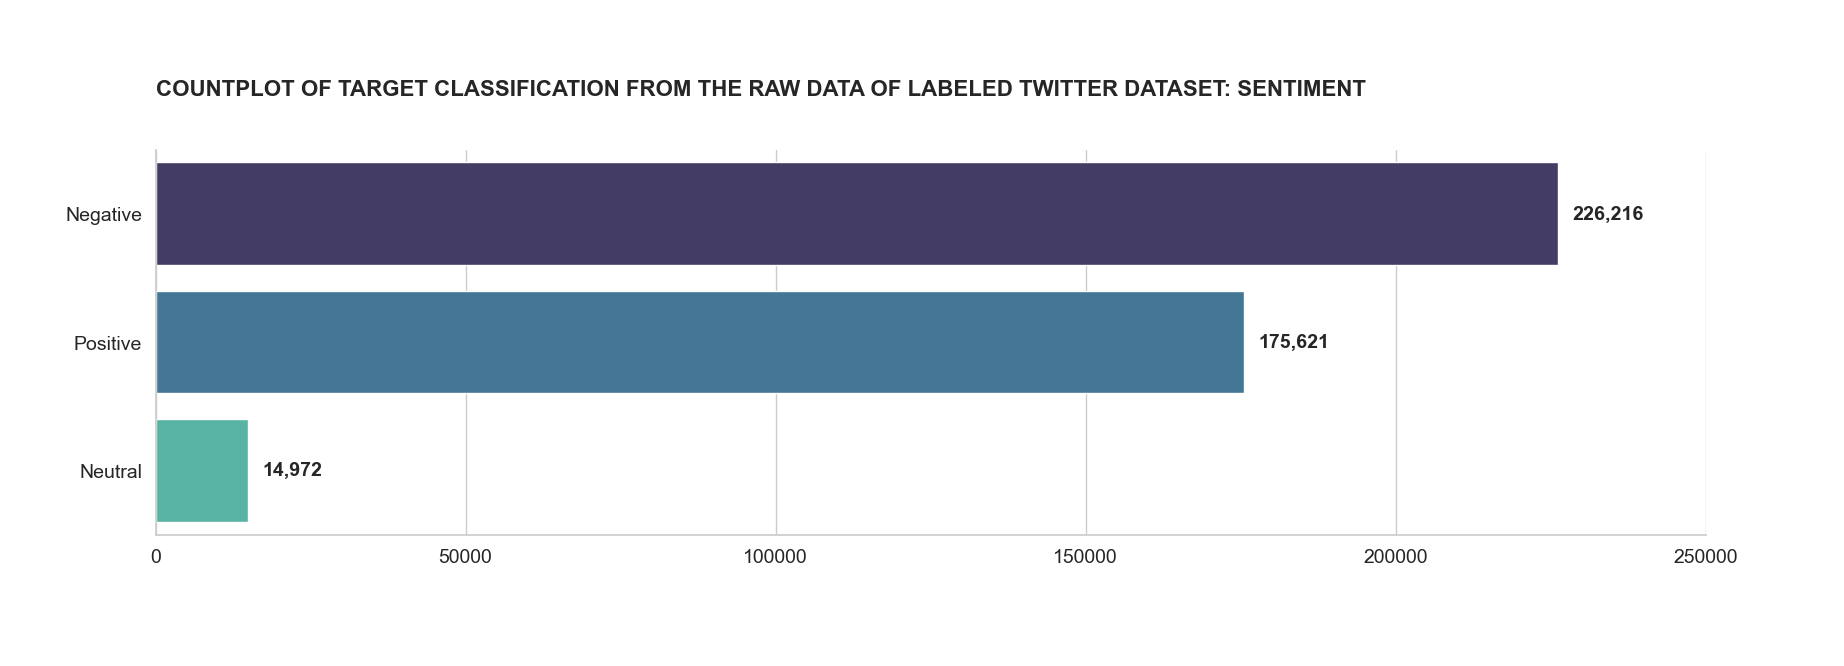

In [13]:
plot_countplot(
  data=df, y='sentiment_label_description',
  title = 'Countplot of target classification from the raw data of labeled twitter dataset: Sentiment',
  height = 5,
);

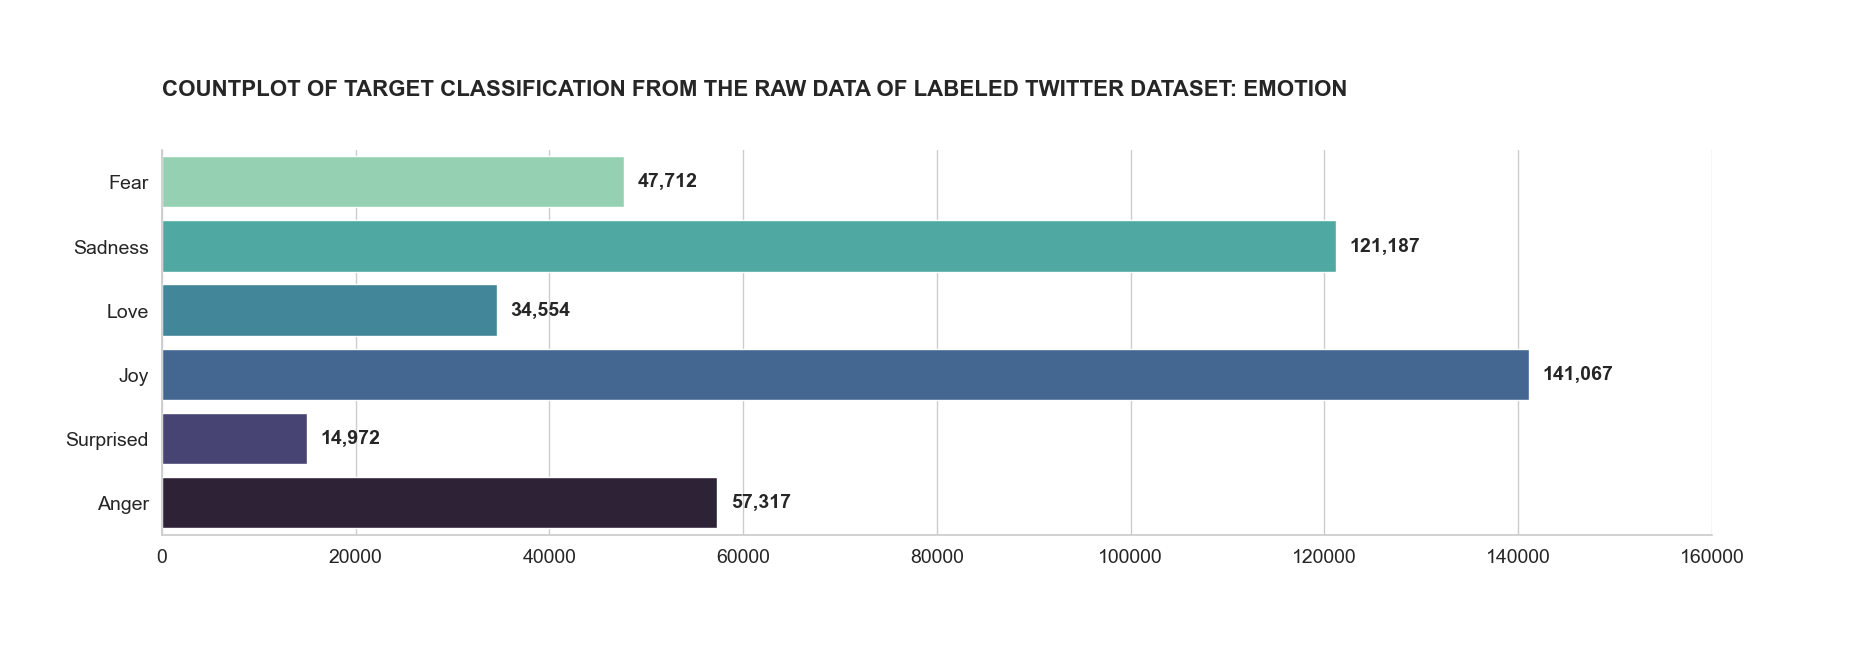

In [14]:
plot_countplot(
  data=df, y='emotion_label_description',
  title='Countplot of target classification from the raw data of labeled twitter dataset: Emotion',
  height=5, palette=palette_a2
);

Casting attributes to the right datatype

In [15]:
category_attribute_list = ['emotion_label_description', 'sentiment_label_description']
integer_attribute_list = ['emotion_label', 'sentiment_label']

for attribute in category_attribute_list:
  df[attribute] = df[attribute].astype('category')

for attribute in integer_attribute_list:
  df[attribute] = df[attribute].astype('int')

In [16]:
df.info(verbose = True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
Index: 416809 entries, 0 to 416808
Data columns (total 5 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   text                         416809 non-null  object  
 1   emotion_label                416809 non-null  int64   
 2   emotion_label_description    416809 non-null  category
 3   sentiment_label              416809 non-null  int64   
 4   sentiment_label_description  416809 non-null  category
dtypes: category(2), int64(2), object(1)
memory usage: 13.5+ MB


## Execution

### Data preprocessing
Making a data pipeline to:
* Denoise: removing the twitter usernames and non-alphabetical characters and stripping it of white space
* Stopwords removal: stripping out the stopwords in the content such as `[a, an, the, and, but, or]` to improve data quality
* Lemmatization: reducing words to their base form e.g. `[changing, changed, change] -> change`

Removing the username and non-alphabetical characters in the content to reduce noise and improve data quality

In [17]:
def denoiser(df: pd.DataFrame):
  def strip(text: str):
    text = re.sub(r'@\w+', '', text) 
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = re.sub(r'https\w+', '', text)
    text = re.sub(r'http\w+', '', text)
    text = text.strip()
    return text.lower()

  df['text'] = df['text'].apply(strip)
  return df

Removing stopwords for standardization

In [18]:
def stopwords_remover(df: pd.DataFrame):
  matcher = re.compile(r"|".join([fr"\b{word}\b" for word in stopwords.words("english")]))
  def remove_stopwords(text: str):
    return " ".join(matcher.sub('', text).split())

  df['text'] = df['text'].apply(remove_stopwords)
  return df

Removing observations with null text values

In [19]:
def null_content_observation_remover(df: pd.DataFrame):
  df = df[~df['text'].isnull()]
  df = df[~df['text'].isin([''])]
  df = df.reset_index(drop=True)
  return df

Removing observations with less than 20 characters to improve model accuracy

In [20]:
def n_characters_content_remover(df: pd.DataFrame, len_limit: int):
  df = df[df['text'].apply(lambda text: len(text) > len_limit)]
  df = df.reset_index(drop=True)
  return df

Reducing words to their base or lemmatizing to enhance the effectiveness of the model

In [21]:
def lemmatizer(df: pd.DataFrame):
  wordnet_lemmatizer = WordNetLemmatizer()
  tokenizer = WordPunctTokenizer()

  wordnet_pos_tag_map = {
    "J": wordnet.ADJ,
    "N": wordnet.NOUN,
    "V": wordnet.VERB,
    "R": wordnet.ADV,
  }

  def lemmatize(text: str):
    tokens = tokenizer.tokenize(text)
    pos_tags = pos_tag(tokens)

    lemmatized_tokens = []
    for token, tag in pos_tags:
      wordnet_tag = wordnet_pos_tag_map.get(tag[0].upper())
      if wordnet_tag is None:
        lemmatized_tokens.append(token)
      else:
        lemmatized_tokens.append(wordnet_lemmatizer.lemmatize(token, wordnet_tag))

    return ' '.join(lemmatized_tokens)

  df['text'] = df['text'].apply(lemmatize)
  return df
    

Running the pipeline and exporting to csv to skip reprocessing of the dataset

In [22]:
if os.path.isfile('data/dataset_processed.csv'):
  df = pd.read_csv('data/dataset_processed.csv')
else:
  df = (
    df
    .pipe(denoiser)
    .pipe(stopwords_remover)
    .pipe(null_content_observation_remover)
    .pipe(n_characters_content_remover, 20)
    .pipe(lemmatizer))

  df.to_csv('data/dataset_processed.csv', index=False)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389684 entries, 0 to 389683
Data columns (total 5 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   text                         389684 non-null  object
 1   emotion_label                389684 non-null  int64 
 2   emotion_label_description    389684 non-null  object
 3   sentiment_label              389684 non-null  int64 
 4   sentiment_label_description  389684 non-null  object
dtypes: int64(2), object(3)
memory usage: 14.9+ MB


In [24]:
df.head()

,text,emotion_label,emotion_label_description,sentiment_label,sentiment_label_description
0,feel really helpless heavy hearted,4,fear,0,negative
1,ive enjoy able slouch relax unwind frankly nee...,0,sadness,0,negative
2,give internship dmrg feeling distraught,4,fear,0,negative
3,kindergarten teacher thoroughly weary job take...,4,fear,0,negative
4,begin feel quite disheartened,0,sadness,0,negative


### Modeling

Initializing the primary variables

In [25]:
x = np.array(df['text'])
y_sentiment = np.array(df['sentiment_label'])
y_emotion = np.array(df['emotion_label'])

TF-IDF Vectorizer to evaluate the importance of a word relative to the collection of documents by combining two metrics:
* **Term Frequency (TF)**: Measures how frequently a term appears in a document. It reflects the local importance of the term within a specific document.
* **Inverse Document Frequency (IDF)**: Measures how important a term is in the entire corpus. It decreases the weight of terms that appear frequently across many documents and increases the weight of terms that are rare.

In [26]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2)).fit(x)

Chi-squared test based feature selector to select the most relevant features for a model based on their relationship with the target variable.
* **Chi-Squared Test:** The Chi-squared test assesses whether the observed frequencies of features (terms) in the dataset differ significantly from expected frequencies. It measures the independence between features and the target variable.
* **Feature Selection with SelectKBest**: SelectKBest uses the Chi-squared test to rank features based on their statistical significance.SelectKBest selects the k features with the highest Chi-squared scores.

In [27]:
selector_sentiment = SelectKBest(chi2, k=4500)
selector_emotion = SelectKBest(chi2, k=4500)

Defining a class to streamline the transformers

In [28]:
class Transformer:
  def __init__(self, x):
    self.x = x

  def vectorizer(self):
    self.x = vectorizer.transform(self.x)
    return self

  def selector(self, selector):
    self.x = selector.transform(self.x)
    return self

  def get_value(self):
    return self.x

Splitting the training and testing data

In [29]:
x_sentiment_train, x_sentiment_test, y_sentiment_train, y_sentiment_test = train_test_split(
  x, y_sentiment,
  test_size=0.25,
  random_state=42,
  stratify=y_sentiment, )

selector_sentiment.fit(
  vectorizer.transform(x_sentiment_train),
  y_sentiment_train, )

x_sentiment_train_selected = (
  Transformer(x_sentiment_train)
  .vectorizer()
  .selector(selector_sentiment)
  .get_value())

x_sentiment_test_selected = (
  Transformer(x_sentiment_test)
  .vectorizer()
  .selector(selector_sentiment)
  .get_value())

In [30]:
x_emotion_train, x_emotion_test, y_emotion_train, y_emotion_test = train_test_split(
  x, y_emotion,
  test_size=0.25,
  random_state=42,
  stratify=y_emotion, )

selector_emotion.fit(
  vectorizer.transform(x_emotion_train),
  y_emotion_train, )

x_emotion_train_selected = (
  Transformer(x_emotion_train)
  .vectorizer()
  .selector(selector_emotion)
  .get_value())

x_emotion_test_selected = (
  Transformer(x_emotion_test)
  .vectorizer()
  .selector(selector_emotion)
  .get_value())


Visualizing the first 10 observations of vectorized data of the sentiment training data

In [31]:
pd.DataFrame(
  vectorizer.transform(x_sentiment_train)[:10].toarray(), 
  columns=vectorizer.get_feature_names_out(), )

,aa,aa blast,aa button,aa config,aa didnt,aa feel,aa finally,aa full,aa linkurl,aa meeting,...,zyrtec feel,zz,zz bleh,zz top,zzz,zzzz,zzzz know,zzzzzz,zzzzzzs,zzzzzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


With how there's still so much noise on the features—a total of 1,311,674 features, feature selection is needed to reduce the dimensionality and improve computational efficiency.

Visualizing the first 10 observations of selected features of the sentiment training data

In [32]:
pd.DataFrame(
  selector_sentiment.transform(vectorizer.transform(x_sentiment_train))[:10].toarray(),
  columns=np.array(vectorizer.get_feature_names_out())[np.array(selector_sentiment.get_support())], )

,abit curious,abit funny,able,able react,absence feeling,absolutely amaze,absolutely amazed,absolutely amazing,absolutely enthral,absolutely ludicrous,...,yastreblyansky,yeah impress,yeah scar,year,year strange,yes dont,yet curious,yet proud,youll pleasantly,youre funny
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.118731,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


Model evaluation visualizer

In [33]:
def visualize_model_evaluation(
  data=None, x=None, y=None, 
  palette=palette_a1, height=5, 
  title=' ', subtitle=' ', description=' ', 
  classification_report=' '):
  
  sns.set(style = 'whitegrid')

  sns.set(
    style='whitegrid',
    rc={'figure.figsize': (13,height)}, )

  g=sns.countplot(
    data=data, y=y,
    palette=palette, 
    hue=y,
    legend=False, )

  g.set_ylabel(' \n\n')
  g.set_xlabel(' \n\n\n\n')

  g.set_title(
    f'\n\n\n{title}\n\n'.upper(),
    loc='left',
    fontdict=dict(
      fontsize=16,
      fontweight='bold', ), )

  g.set_yticks(g.get_yticks())
  g.set_yticklabels(
    [tick_label.get_text().title() for tick_label in g.get_yticklabels()],
    fontdict=dict(
      fontsize=14,
      fontweight='medium', ), )

  g.set_xticks(g.get_xticks())
  g.set_xticklabels(
    [tick_label.get_text().title() for tick_label in g.get_xticklabels()],
    fontdict=dict(
      fontsize=14,
      fontweight='medium', ), )

  plt.text(
    s=f'{subtitle}',
    alpha=0.5, x=0, y=1.05,
    horizontalalignment='left',
    transform=g.transAxes, )

  plt.text(
    s=f'{description}',
    alpha=0.5, x=0, y=-.18,
    verticalalignment='baseline',
    horizontalalignment='left',
    transform=g.transAxes, )

  for container in g.containers:
    labels = g.bar_label(
      container=container,
      padding=10,
      fmt=lambda x: f'{x / len(data) * 100:.1f}%', )
    
    for label in labels:
      label.set_fontsize(14)
      label.set_fontweight('bold') 

  plt.text(
    s=' ', x=1.7, y=1,
    transform=g.transAxes, )
  
  plt.text(
    s=classification_report.upper(), x=1.1, y=0.25,
    alpha=0.8, transform=g.transAxes,
    fontdict=dict(fontfamily='monospace'))

  sns.despine()

  return g

#### Training the sentiment classifier

In [34]:
model_sentiment = MultinomialNB()

Grid search and cross validation hyperparameter tuning to select the best parameters and yield better accuracy

In [35]:
gridsearch_model_sentiment = GridSearchCV(
  estimator=model_sentiment,
  param_grid={'alpha': [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.8, 0.9, 1.0, 1.1, 1.2]},
  cv=5,
  scoring='accuracy', )

gridsearch_model_sentiment.fit(
  x_sentiment_train_selected, 
  y_sentiment_train, )

gridsearch_model_sentiment.best_params_

{'alpha': 0.02}

In [36]:
gridsearch_model_sentiment.best_score_

np.float64(0.9412173222535307)

In [37]:
model_sentiment = gridsearch_model_sentiment.best_estimator_

In [38]:
df_sentiment_results = pd.DataFrame({
  'actual_value': y_sentiment_test,
  'predicted_value': model_sentiment.predict(x_sentiment_test_selected)
})

df_sentiment_results['classification'] = df_sentiment_results.apply(
  lambda x:
    'true positive' if x['actual_value'] == 1 and x['predicted_value'] == 1 else
    'true negative' if x['actual_value'] == 0 and x['predicted_value'] == 0 else
    'true neutral' if x['actual_value'] == 2 and x['predicted_value'] == 2 else
    'false positive' if x['actual_value'] != 1 and x['predicted_value'] == 1 else
    'false negative' if x['actual_value'] != 0 and x['predicted_value'] == 0 else
    'false neutral' if x['actual_value'] != 2 and x['predicted_value'] == 2 else
    None
  , axis=1
)

Visualize model evaluation

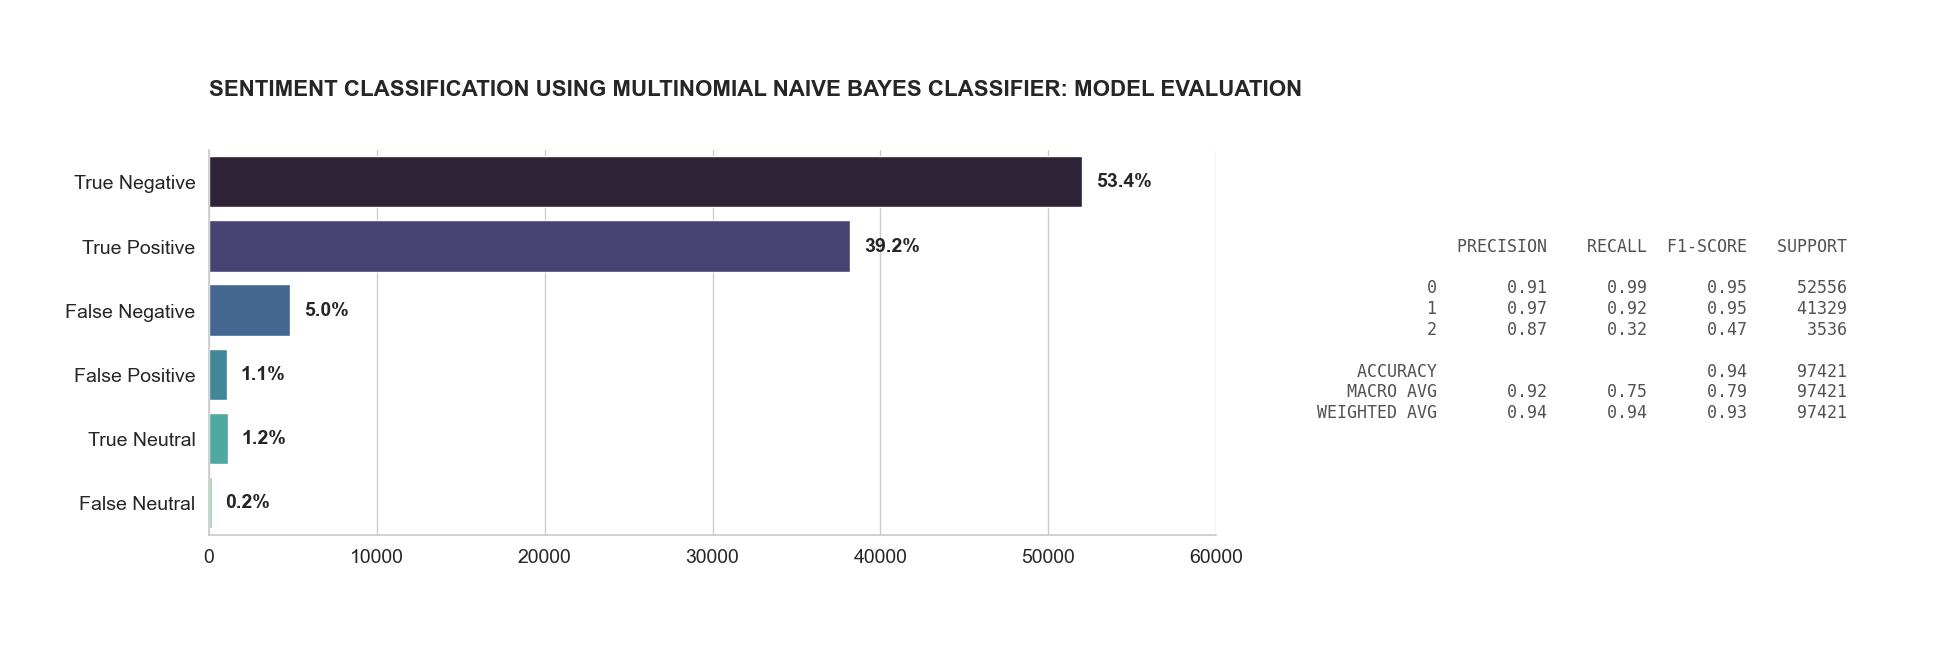

In [39]:
classification_report_model_sentiment = classification_report(
  df_sentiment_results['actual_value'], 
  df_sentiment_results['predicted_value'], )

visualize_model_evaluation(
  data=df_sentiment_results, y='classification',
  title='Sentiment classification using multinomial naive bayes classifier: model evaluation',
  height=5, palette=palette_a1, 
  classification_report=classification_report_model_sentiment, );

In [40]:
response_list = [
  "I believe online anonymity encourages more honest and open communication, allowing users to express their true opinions",
  "In my view, online anonymity can lead to a significant increase in negative behaviors, such as trolling and cyberbullying, because users feel shielded from accountability.",
  "I think anonymity provides a double-edged sword; while it allows for free expression, it also creates an environment where people may engage in harmful or deceitful actions.",
  "Online anonymity empowers marginalized voices to speak out, but it also makes it difficult to identify and address harmful content effectively.",
  "I see online anonymity as a critical factor in fostering diverse discussions, but it also contributes to the spread of misinformation, as sources cannot always be verified.",
  "I think that online anonymity can lead to more genuine interactions in certain communities, but it may also reduce the quality of discourse by enabling users to avoid responsibility for their words.",
  "Anonymity online is essential for privacy, but it can also encourage users to engage in behavior they might avoid if their identity were known.",
  "In my opinion, the impact of online anonymity is largely context-dependent; it can promote both positive and negative behaviors depending on the platform and community norms.",
  "I believe online anonymity amplifies both the best and worst aspects of human behavior, providing a space for both creativity and cruelty.",
  "I think online anonymity allows people to connect more authentically, but it can also lead to a lack of trust and credibility in online interactions."
]

test = (pd.DataFrame({'text': response_list})
  .pipe(denoiser)
  .pipe(stopwords_remover)
  .pipe(null_content_observation_remover)
  .pipe(lemmatizer))

model_sentiment.predict(
  Transformer(test['text'])
  .vectorizer()
  .selector(selector_sentiment)
  .get_value())


array([1, 1, 1, 1, 0, 1, 1, 1, 0, 0])

#### Training the emotion classifier

In [41]:
model_emotion = MultinomialNB()

Grid search and cross validation hyperparameter tuning to select the best parameters and yield better accuracy

In [42]:
gridsearch_model_emotion = GridSearchCV(
  estimator=model_emotion,
  param_grid={'alpha': [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.8, 0.9, 1.0, 1.1, 1.2]},
  cv=5,
  scoring='accuracy', )

gridsearch_model_emotion.fit(
  x_emotion_train_selected, 
  y_emotion_train, )

gridsearch_model_emotion.best_params_

{'alpha': 0.02}

In [43]:
gridsearch_model_emotion.best_score_

np.float64(0.8467613146065893)

In [44]:
model_emotion = gridsearch_model_emotion.best_estimator_

In [45]:
df_emotion_results = pd.DataFrame({
  'actual_value': y_emotion_test,
  'predicted_value': model_emotion.predict(x_emotion_test_selected)
})

df_emotion_results['classification'] = df_emotion_results.apply(
  lambda x:
    'true sadness' if x['actual_value'] == 0 and x['predicted_value'] == 0 else
    'true joy' if x['actual_value'] == 1 and x['predicted_value'] == 1 else
    'true love' if x['actual_value'] == 2 and x['predicted_value'] == 2 else
    'true anger' if x['actual_value'] == 3 and x['predicted_value'] == 3 else
    'true fear' if x['actual_value'] == 4 and x['predicted_value'] == 4 else
    'true surprised' if x['actual_value'] == 5 and x['predicted_value'] == 5 else
    'false sadness' if x['actual_value'] != 0 and x['predicted_value'] == 0 else
    'false joy' if x['actual_value'] != 1 and x['predicted_value'] == 1 else
    'false love' if x['actual_value'] != 2 and x['predicted_value'] == 2 else
    'false anger' if x['actual_value'] != 3 and x['predicted_value'] == 3 else
    'false fear' if x['actual_value'] != 4 and x['predicted_value'] == 4 else
    'false surprised' if x['actual_value'] != 5 and x['predicted_value'] == 5 else
    None
  , axis=1
)

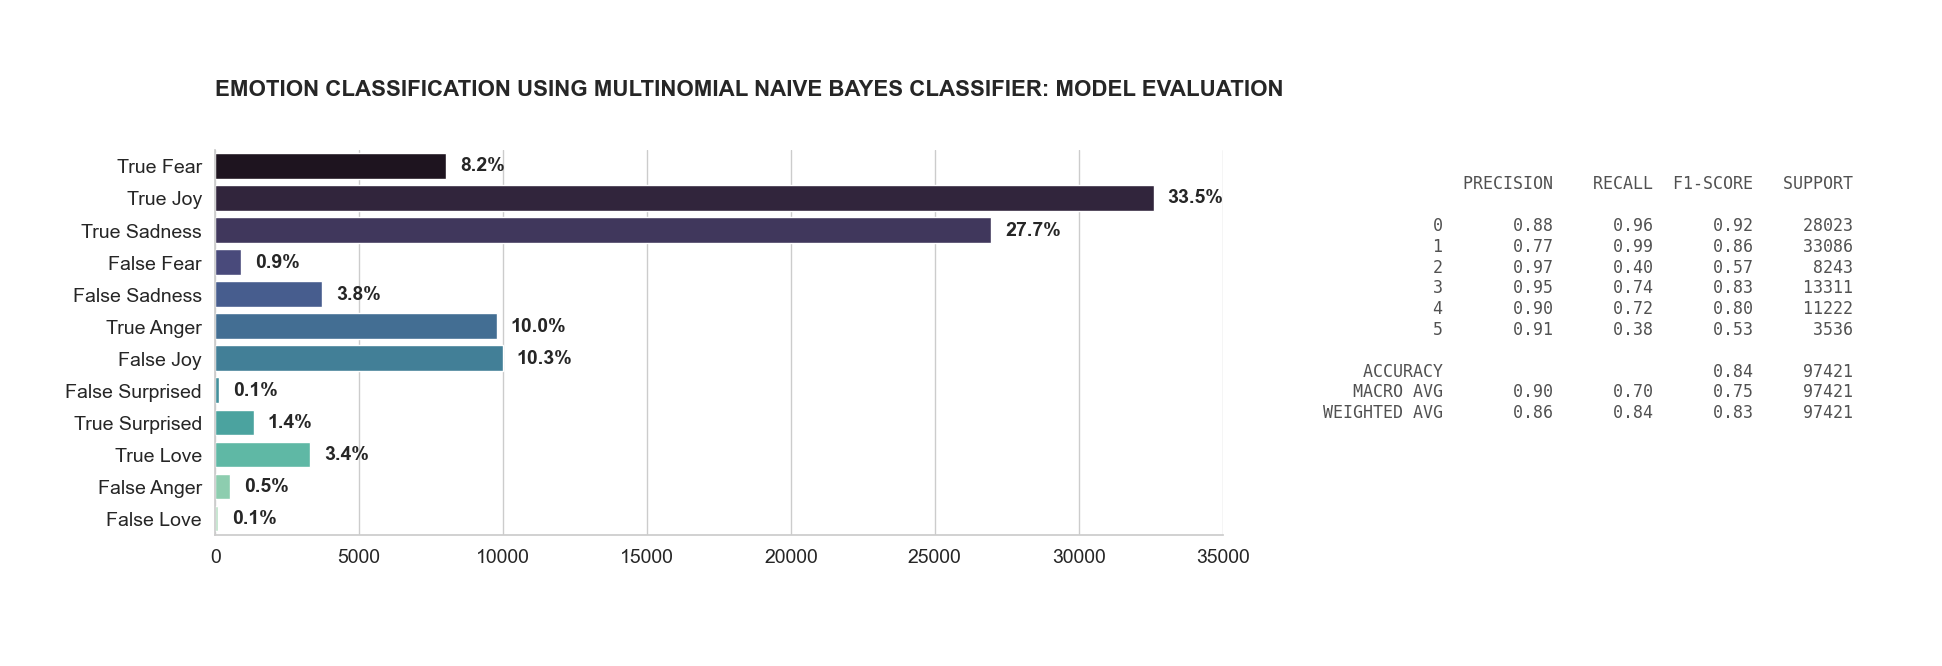

In [46]:
classification_report_model_emotion = classification_report(
  df_emotion_results['actual_value'], 
  df_emotion_results['predicted_value'], )

visualize_model_evaluation(
  data=df_emotion_results, y='classification',
  title='Emotion classification using multinomial naive bayes classifier: model evaluation',
  height=5, palette=palette_a1, 
  classification_report=classification_report_model_emotion, );

In [47]:
response_list = [
  "I believe online anonymity encourages more honest and open communication, allowing users to express their true opinions",
  "In my view, online anonymity can lead to a significant increase in negative behaviors, such as trolling and cyberbullying, because users feel shielded from accountability.",
  "I think anonymity provides a double-edged sword; while it allows for free expression, it also creates an environment where people may engage in harmful or deceitful actions.",
  "Online anonymity empowers marginalized voices to speak out, but it also makes it difficult to identify and address harmful content effectively.",
  "I see online anonymity as a critical factor in fostering diverse discussions, but it also contributes to the spread of misinformation, as sources cannot always be verified.",
  "I think that online anonymity can lead to more genuine interactions in certain communities, but it may also reduce the quality of discourse by enabling users to avoid responsibility for their words.",
  "Anonymity online is essential for privacy, but it can also encourage users to engage in behavior they might avoid if their identity were known.",
  "In my opinion, the impact of online anonymity is largely context-dependent; it can promote both positive and negative behaviors depending on the platform and community norms.",
  "I believe online anonymity amplifies both the best and worst aspects of human behavior, providing a space for both creativity and cruelty.",
  "I think online anonymity allows people to connect more authentically, but it can also lead to a lack of trust and credibility in online interactions."
]

test = (pd.DataFrame({'text': response_list})
  .pipe(denoiser)
  .pipe(stopwords_remover)
  .pipe(null_content_observation_remover)
  .pipe(lemmatizer))

model_emotion.predict(
  Transformer(test['text'])
  .vectorizer()
  .selector(selector_emotion)
  .get_value())


array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1])

Saving the vectorizer, selector, and model locally

In [49]:
with open('pkl/tfidf_vectorizer.pkl', 'wb') as file:
  pickle.dump(vectorizer, file)
  
with open('pkl/selector_sentiment.pkl', 'wb') as file:
  pickle.dump(selector_sentiment, file)
  
with open('pkl/selector_emotion.pkl', 'wb') as file:
  pickle.dump(selector_emotion, file)
  
with open('pkl/model_sentiment.pkl', 'wb') as file:
  pickle.dump(model_sentiment, file)
  
with open('pkl/model_emotion.pkl', 'wb') as file:
  pickle.dump(model_emotion, file)